In [1]:
import pandas as pd                                                                
import numpy as np                                                                 
import matplotlib.pyplot as plt                                                    
from sklearn.neighbors import KNeighborsRegressor                                  
from Signalprocessing import Convolution                                                
import seaborn as sns                                                              
sns.set()                                                                         
from ipywidgets import HBox, Label, IntSlider, widgets, FloatSlider, interactive_output, VBox, fixed
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

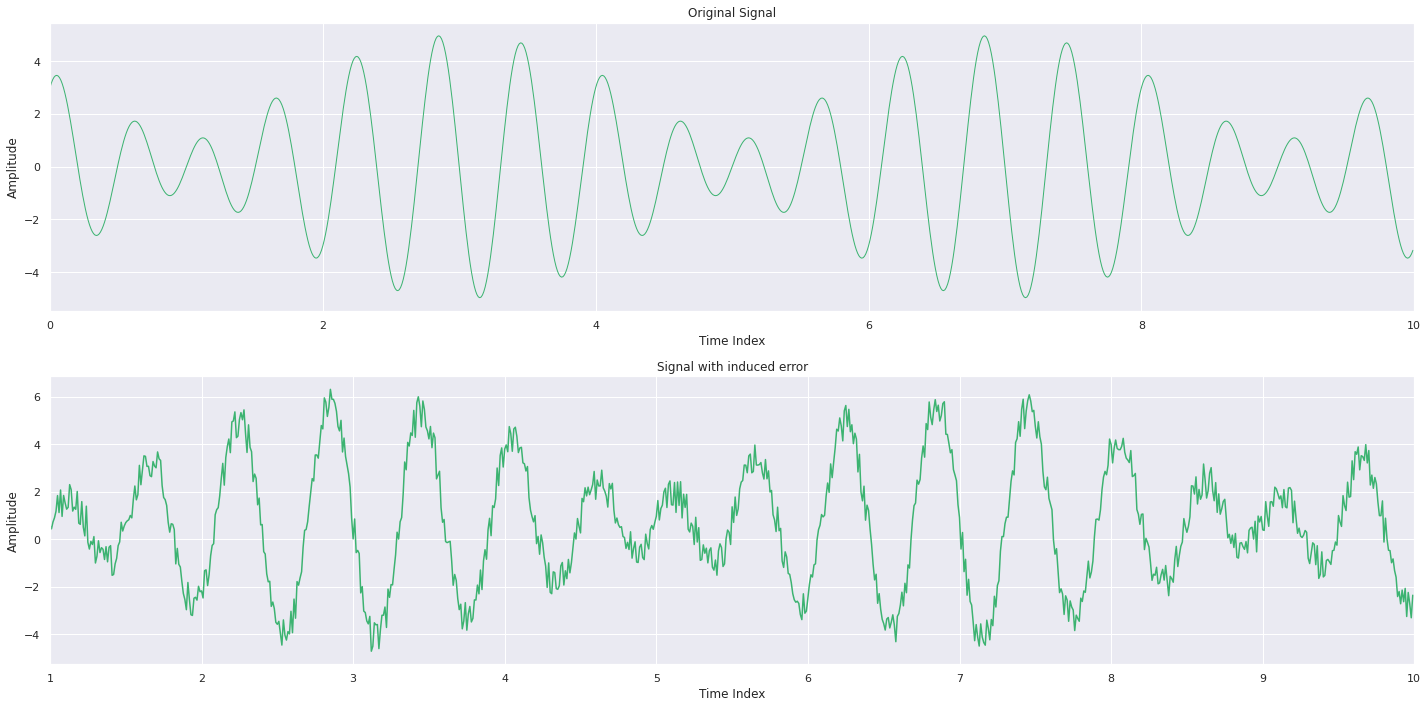

In [2]:
#generating signal                                                                 
t = np.arange(0,10, 0.01)                                                          
orig_signal = 2 *np.sin(2 * np.pi * 1.5 * t) + 3 * np.cos(2 * np.pi * 1.75 * t)    
err = np.random.rand(len(t))                                                       
signal = orig_signal + err * 1.5                                                   
fig, ax = plt.subplots(nrows = 2, figsize=(20, 10))                                                  
ax[0].plot(t, orig_signal, linewidth=1, color='mediumseagreen')                                            
ax[0].set_title('Original Signal')                                                 
ax[0].set_xlabel("Time Index")                                                     
ax[0].set_ylabel('Amplitude')                                                      
ax[0].set_xlim(0, 10)                                                              
ax[1].plot(t, signal, color='mediumseagreen')                                                              
ax[1].set_title('Signal with induced error')                                       
ax[1].set_xlabel("Time Index")                                                     
ax[1].set_ylabel('Amplitude')                                                      
ax[1].set_xlim(1, 10)                                                              
fig.tight_layout()                                                                 
plt.show() 

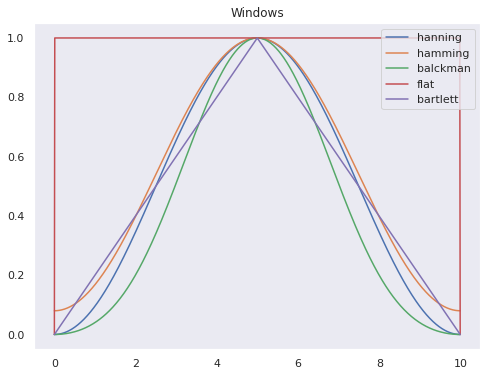

In [3]:
#Different window functions 
window_len = len(t)
hanning = np.hanning(window_len)
hamming = np.hamming(window_len)
blackman = np.blackman(window_len)
flat = np.r_[[0], np.ones(window_len-2), [0]]
bartlett = np.bartlett(window_len)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.plot(t, hanning, label = 'hanning')
ax.plot(t, hamming, label = 'hamming')
ax.plot(t, blackman, label = 'balckman')
ax.plot(t, flat, label = 'flat')
ax.plot(t, bartlett, label = 'bartlett')
ax.legend(loc = 1)
ax.grid()
ax.set_title('Windows')
plt.show()

In [4]:
#just for capturing standard deviation of the signal.
default_window_len = 15

#function to plot convoluted signal 
def interactive_plot_convolution(window, err_mul = 1, win_len=10):                                       
    t = np.arange(0, 10 , 0.01)                                                    
    orig_signal = 2 *np.sin(2 * np.pi * 1.5 * t) + 3 * np.cos(2 * np.pi * 1.75 * t)
    np.random.seed(69)
    error = np.random.rand(len(t))                                                 
    signal = orig_signal + error * err_mul                              
    conv_obj = Convolution()                                                       
    out_signal = conv_obj.convolute(window, win_len, signal)                 
    signal = pd.Series(signal)
    fig, ax = plt.subplots(nrows=1, figsize=(25,10))                                                
    ax.fill_between(t, signal+signal.rolling(default_window_len).std(), signal-signal.rolling(default_window_len).std(), facecolor='lightseagreen',alpha=0.5, label='Signal')
    ax.plot(t, out_signal, color='black', label='Convoluted Signal')
    ax.legend()
    ax.set_xlim(0,10)
    ax.set_title("Using Convolution")
    plt.show()

In [5]:
errslider = widgets.FloatSlider(min=0.00, max=3.00,step= 0.01, value=1.00)
winslider = widgets.IntSlider(min=3, max=100, step=1, value=10)
windlist = widgets.Dropdown(options=['flat', 'hanning', 'hamming', 'blackman', 'bartlett'], value='flat')
hbox1 = widgets.HBox([Label('WINDOW LENGTH:'), winslider])
hbox2 = widgets.HBox([Label('ERROR MULTIPLIER:'), errslider])
hbox3 = widgets.HBox([Label('WINDOW:'), windlist])
HBOX1 = VBox([hbox1, hbox2])
ui = HBox([HBOX1, hbox3])
#display(ui)

In [6]:
out = interactive_output(interactive_plot_convolution, {'err_mul':errslider, 'win_len':winslider, 'window':windlist})
display(ui, out)

Output()

In [7]:
def interactive_plot_kn(err_mult=1, win_len=10):
    t = np.arange(0, 10 , 0.01)                                                    
    orig_signal = 2 *np.sin(2 * np.pi * 1.5 * t) + 3 * np.cos(2 * np.pi * 1.75 * t)
    np.random.seed(69)
    error = np.random.rand(len(t))                                                 
    signal = orig_signal + error * err_mult
    regressor = KNeighborsRegressor(n_neighbors=win_len, weights='uniform')
    regressor.fit(t[:,np.newaxis], signal)
    out_signal = regressor.predict(t[:,np.newaxis])
    signal = pd.Series(signal)
    fig, ax = plt.subplots(nrows=1, figsize=(25,10))                                                
    ax.fill_between(t, signal+signal.rolling(default_window_len).std(), signal-signal.rolling(default_window_len).std(), facecolor='lightseagreen',alpha=0.5, label='Signal')
    ax.plot(t, out_signal, color='black', label='Processed Signal')
    ax.legend()
    ax.set_xlim(0,10)
    ax.set_title("Using KNeighbourRegressor")
    plt.show()
    

In [8]:
errslider = widgets.FloatSlider(min=0.0, max=3.0, step=0.01, value=1.0)
winslider = widgets.IntSlider(min=3, max=100, step=1, value=10)
hbox1 = HBox([Label('ERROR MULTIPLIER'), errslider])
hbox2 = HBox([Label('WINDOW LENGTH'), winslider])
ui = VBox([hbox1, hbox2])
#display(ui)

In [9]:
out = interactive_output(interactive_plot_kn, {'err_mult':errslider, 'win_len':winslider})
display(ui, out)

Output()

In [10]:
df = pd.read_csv('seg_004314.csv')
signal = np.array(df['acoustic_data'])

In [11]:
def convolute_1D_signal(signal, window, xmin, xmax, win_len):
    if xmin > xmax:
        raise ValueError('xmin cannot be greater than xmax')
    t = np.arange(len(signal))
    signal = signal[xmin:xmax]
    t = t[xmin:xmax]
    conv = Convolution()
    out_signal = conv.convolute(window, win_len, signal)
    fig, ax = plt.subplots(nrows=1, figsize=(25,10))
    ax.plot(t, signal, color='lightseagreen', alpha=0.5, label='Original Signal')
    ax.plot(t, out_signal, color='black', label='Processed Signal')
    ax.set_title('Using Convolution')
    ax.legend()
    plt.show()
    

In [12]:
xminslider = widgets.IntSlider(min=df.index.min(), max=df.index.max(), step=10, value = df.index.min())
xmaxslider = widgets.IntSlider(min=df.index.min(), max=df.index.max(), step=10, value = df.index.max())
winslider = widgets.IntSlider(min=0, max=100, step=1, value=25)
windopt = widgets.Dropdown(options=['flat', 'hanning', 'hamming', 'blackman', 'bartlett'], value='flat')
hbox1 = HBox([Label('XMIN'), xminslider])
hbox2 = HBox([Label('XMAX'), xmaxslider])
hbox3 = HBox([Label('WINDOW LENGTH'), winslider])
hbox4 = HBox([Label('WINDOW'), windopt])
HBOX1 = VBox([hbox1, hbox2])
HBOX2 = VBox([hbox3, hbox4])
ui = HBox([HBOX1, HBOX2])
#display(ui)

In [13]:
out = interactive_output(convolute_1D_signal, {'signal':fixed(signal), 'window':windopt, 'xmin':xminslider, 'xmax':xmaxslider, 'win_len':winslider})
display(ui, out)

Output()

In [14]:
def using_Kn(signal, win_len, xmax, xmin):
    if xmin > xmax:
        raise ValueError('xmin cannot be greater than xmax')
    t = np.arange(len(signal))
    signal = signal[xmin:xmax]
    t = t[xmin:xmax]
    regressor = KNeighborsRegressor(n_neighbors=win_len, weights='uniform', n_jobs=-1)
    regressor.fit(t[:, np.newaxis], signal)
    out_signal = regressor.predict(t[:,np.newaxis])
    fig, ax = plt.subplots(nrows=1, figsize=(25,10))
    ax.plot(t, signal, color='lightseagreen', alpha=0.5, label='Original Signal')
    ax.plot(t, out_signal, color='black', label='Processed Signal')
    ax.set_title('Using KNeighbourRegressor')
    ax.legend()
    plt.show()
        
    

In [15]:
xminslider = widgets.IntSlider(min=df.index.min(), max=df.index.max(), step=10, value = df.index.min(), continuous_update=False)
xmaxslider = widgets.IntSlider(min=df.index.min(), max=df.index.max(), step=10, value = df.index.max(), continuous_update=False)
winslider = widgets.IntSlider(min=0, max=100, step=1, value=25)
hbox1 = HBox([Label('XMIN'), xminslider])
hbox2 = HBox([Label('XMAX'), xmaxslider])
hbox3 = HBox([Label('WINDOW LENGTH'), winslider])
HBOX1 = VBox([hbox1, hbox2])
ui = HBox([HBOX1, hbox3])
#display(ui)

In [16]:
#Aet XMIN~15,000 and XMAX~28,000 and then change the widow length to really see the effect. the code will take a few seconds to run.
out = interactive_output(using_Kn, {'signal':fixed(signal), 'win_len':winslider, 'xmax':xmaxslider, 'xmin':xminslider})
display(ui, out)

Output()